## POC in a word perspective

### Main Algorithm:

1. Lemmatization

2. Protect stop words


3. // words (key phrases)   
Do:   
	Look for similar words (DBSCAN)   
Replace with centroid / one of the members   
Until Embedding distance is too high or utilization is too low.   


4. // sentences   
While K-anonymity is not reached:   
Find most similar sentences (Jaccard distance)   
Force them to be similar   

5. Do some utilization test / give some stats…


In [63]:
# For VSCODE
%reload_ext autoreload
%autoreload 2

## 0) Upload data

Import libraries

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

Import project files

In [65]:
from utils import nlp_utils, cluster_utils, utilization_utils, anonym_utils

Uploading data

In [66]:
train_file = 'data/df_filtered_1000.csv'  # working on small portion of the dataset
output_name = '1000_example.csv'

Getting dataframe

In [67]:
%%time
# df from csv
df = pd.read_csv(train_file)

Wall time: 81.4 ms


In [68]:
df.head()

,Unnamed: 0,txt,sentiment,num_of_words
0,99,"caution!: these tracks are not the ""original"" ...",0,22
1,461,just awful: this was possibly the worst book i...,0,25
2,493,no lessons learned: this is one of the most di...,0,23
3,578,squeem: i ordered according to the size chart ...,0,21
4,595,"pass: the sizes run really small, it flips up ...",0,25


## 1+2) Lemmatizing and protecting stopwords

Defininig the protected word list

In [98]:
nlp_utils.init_stopwords()

In [69]:
wide_stop_words = False  
if wide_stop_words:  # taking a list of 1000 most common words in english and define them as stop_words
    nlp_utils.add_word_list_to_stop_words('data/1000_most_common_words.txt')
else:  # taking a shorter list of stop_words from NLTK
    nlp_utils.stopword_list = nlp_utils.stopwords.words('english')
print('Number of protected words:', len(nlp_utils.stopword_list))
print(nlp_utils.stopword_list[:10])

Number of protected words: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Defining the word dictionary

In [70]:
%%time
word_dict = nlp_utils.create_word_dict(df['txt'])
word_list = cluster_utils.get_word_list_for_clustering(word_dict)

Wall time: 16.3 s


In [71]:
print('Number of different words:', len(word_dict))

Number of different words: 3281


## 3) Word replacement

### 3.1) Clustering using DBSCAN

#### 3.1.1) Using DBSCAN with the default euclidean distance

Embedding the word list using a pre-defined model 
current: glove
wanted: W2V

In [72]:
embedded_dict = cluster_utils.embed_corpus(word_list)

Clustering

#### 3.1.2) Using DBSCAN with cosine distance

Testing DBSCAN with cosine metric

In [76]:
eps_cos = cluster_utils.define_eps_cos()
eps_cos

mean similarity between good pairs	 0.8497384
mean similarity between bad pairs	 0.57323164


0.3036462068557739

In [78]:
cluster_dict_cos, dist_dict_cos, labels_cos = cluster_utils.run_clustering(embedded_dict, cosine=True,eps=eps_cos)

eps 0.3036462068557739
(0, ['read', 'jack', 'dream', 'wonder', 'nearly', 'dvr', 'sit', 'remastere', 'later', 'durable', 'lack', 'mgm', 'clip', 'view', 'smith', 'saint', 'sung', 'va', 'refresher', 'man', 'hypnotise', 'toy', 'nott', 'fill', 'rash', 'publish', 'bore', 'coin', 'support', 'remove', 'complicate', 'apply', 'cudnt', 'piece', 'grateful', 'mug', 'realy', 'competitive', 'fit', 'dictionary', 'pay', 'vanity', 'scenery', 'access', 'window', 'start', 'call', 'beautiful', 'website', 'generalization', 'laughoutloud', 'supersonic', 'wonderfully', 'mother', 'nasty', 'seed', 'december', 'eclectic', 'official', 'upbeat', 'player', 'loose', 'arrival', 'karate', 'include', 'realistic', 'exaggerate', 'due', 'fascinate', 'spanx', 'stuffy', 'drink', 'death', 'information', 'alpine', 'bean', 'insert', 'avoid', 'custom', 'forget', 'bash', 'item', 'irritate', 'incomplete', 'pleasantly', 'turner', 'wow', 'catholic', 'ridiculously', 'unfortunately', 'prayer', 'typical', 'mail', 'nicely', 'monitor', 

In [81]:
cluster_dict, dist_dict, labels = cluster_utils.run_clustering(embedded_dict, cosine=False,eps=eps_euc/2)

eps 1.7833735942840576
(-1, ['read', 'dream', 'nearly', 'dvr', 'sit', 'remastere', 'later', 'durable', 'lack', 'mgm', 'clip', 'view', 'saint', 'sung', 'va', 'refresher', 'man', 'hypnotise', 'toy', 'nott', 'rash', 'publish', 'kota', 'bore', 'coin', 'support', 'remove', 'complicate', 'apply', 'cudnt', 'piece', 'grateful', 'mug', 'realy', 'competitive', 'fit', 'pay', 'vanity', 'scenery', 'access', 'window', 'start', 'call', 'beautiful', 'website', 'generalization', 'laughoutloud', 'supersonic', 'wonderfully', 'seed', 'eclectic', 'official', 'upbeat', 'player', 'karate', 'include', 'exaggerate', 'due', 'fascinate', 'spanx', 'stuffy', 'drink', 'death', 'information', 'alpine', 'bean', 'insert', 'avoid', 'custom', 'agan', 'bash', 'item', 'irritate', 'incomplete', 'pleasantly', 'catholic', 'ridiculously', 'prayer', 'typical', 'mail', 'nicely', 'monitor', 'professor', 'storyline', 'download', 'saddest', 'w', 'description', 'feature', 'annoying', 'work', 'price', 'absolute', 'classic', 'knee', 

In [93]:
dist_dict[14]

0.26827952

5 clusters


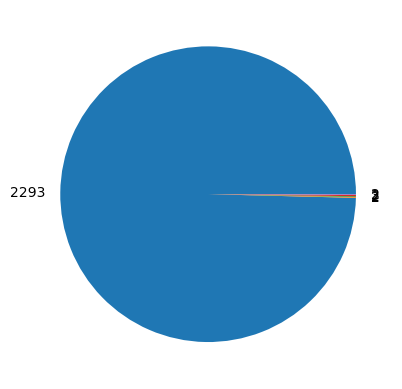

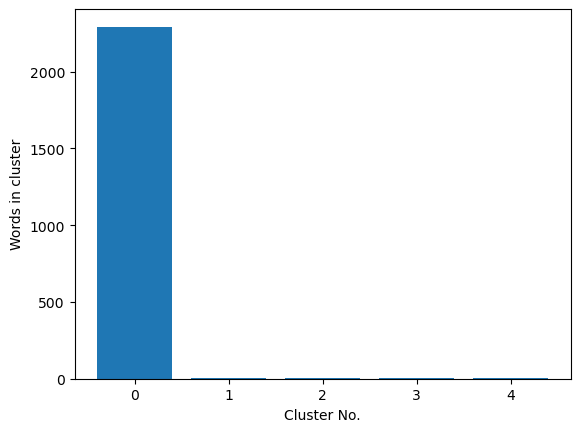

In [82]:
cluster_utils.plot_cluster_size_distribution_2(cluster_dict_cos)  # run the funcion while ignoring (-1 cluster)

113 clusters


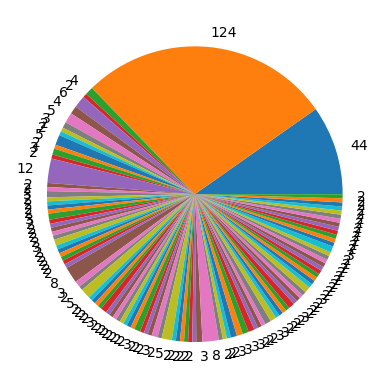

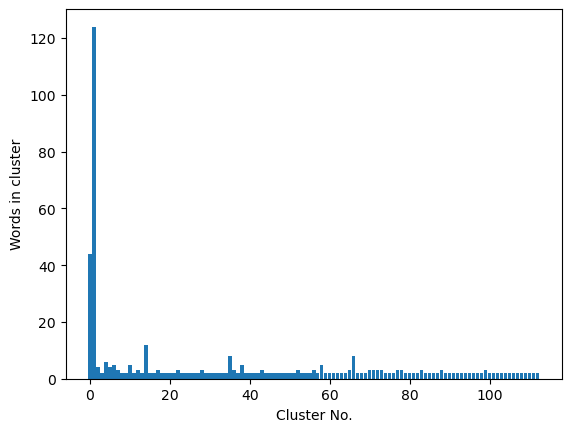

In [83]:
cluster_utils.plot_cluster_size_distribution_2(cluster_dict)  # run the funcion while ignoring (-1 cluster)

#### 3.1.4) Comapirson

# need to re-evaluate where running with word2vec

In [ ]:
print('Euclidian distance:\t', len(cluster_dict), 'clusters')
print('Cosine distance:\t', len(cluster_dict_cos), 'clusters')


Euclidian distance:	 109 clusters
Cosine distance:	 110 clusters


Getting distance threshold

In [ ]:
eps_cos = cluster_utils.define_eps_cos()
eps_cos

mean similarity between good pairs	 0.8497384
mean similarity between bad pairs	 0.57323164


0.3036462068557739

In [79]:
eps_euc = cluster_utils.define_eps_euc()
eps_euc

mean distance between good pairs	 2.6268718
mean distance between bad pairs	 4.3884535


3.5667471885681152

## DBSCAN WITH A PRE_DEFINED EPSILON:

### ADD here the code for running dbscan with:
 - word2vec embedding
 - predifined epsilon (cose/eucl)
 - plot results and examples for clustering


In [59]:
cluster_dict, dist_dict, labels = cluster_utils.run_clustering(embedded_dict, cosine=False, eps = eps_euc/2)

eps 1.7833735942840576


### 3.2) Replacing words in documents

#### 3.2.1) Based on Eucledian distance

In [ ]:
# the function replace_words_in_df performs dbscan with pre defined eps, and changes the

In [43]:
%%time
# here the epshilon used to create the clusers - now, which threshold will be used to limit the clusters that are too big??
df_2, word_dict_2 = nlp_utils.replace_words_in_df(df, cluster_dict, dist_dict, eps_euc, word_dict)

Starting average Jaccard index: 0.18147864872826147
Distance threshold: 0.3036462068557739
distance: 0.5429582 the next cluster is too wide and wont be replaced: ['read', 'jack', 'dream', 'wonder', 'nearly', 'dvr', 'sit', 'remastere', 'later', 'durable', 'lack', 'mgm', 'clip', 'view', 'smith', 'saint', 'sung', 'refresher', 'man', 'hypnotise', 'toy', 'nott', 'fill', 'rash', 'publish', 'bore', 'coin', 'support', 'remove', 'complicate', 'apply', 'cudnt', 'piece', 'grateful', 'mug', 'realy', 'competitive', 'fit', 'dictionary', 'pay', 'vanity', 'scenery', 'access', 'window', 'start', 'call', 'beautiful', 'website', 'generalization', 'laughoutloud', 'supersonic', 'wonderfully', 'mother', 'nasty', 'seed', 'december', 'eclectic', 'official', 'upbeat', 'player', 'loose', 'arrival', 'karate', 'include', 'realistic', 'exaggerate', 'due', 'fascinate', 'spanx', 'stuffy', 'drink', 'death', 'information', 'alpine', 'bean', 'insert', 'avoid', 'custom', 'agan', 'forget', 'bash', 'item', 'irritate', 'in

In [39]:
df_2.txt.iloc[0]

'caution!: these tracks are not the "original" versions but are re-recorded versions. so, whether the tracks are "remastered" or not is irrelevant.'

In [42]:
df_2.anon_txt.iloc[0]

'caution ! : these track are not the " original " version but are re - recorded version . so , whether the track are " remastere " or not is irrelevant .'

#### 3.2.2) Based on Cosine distance

In [100]:
%%time
# def replace_words_in_df(df_0, cluster_dict, distance_dict, word_dict_0, update_stop=True, threshold=None):

df_3, word_dict_3 = nlp_utils.replace_words_in_df(df, cluster_dict, dist_dict, word_dict)

Starting average Jaccard index: 0.18490998931057948
Distance threshold: None
distance: 0.29506308 	replacing ['jack', 'smith', 'turner', 'thomas', 'rebecca', 'paul', 'paxton', 'robert', 'scarlett', 'joe', 'chandler', 'dane', 'keith', 'christine', 'henry', 'kerouac', 'mark', 'duncan', 'tony', 'sylvia', 'carter', 'john', 'johnson', 'phillip', 'browne', 'quigley', 'kelly', 'michael', 'miller', 'ray', 'gilbert', 'peggy', 'mrs', 'clark', 'james', 'sherry', 'joseph', 'cornwell', 'lightfoot', 'boyer', 'elizabeth', 'meyer', 'shirley', 'mason'] in collins
distance: 0.33075345 	replacing ['wonder', 'forget', 'wow', 'unfortunately', 'hit', 'yesterday', 'necessary', 'hold', 'obviously', 'straight', 'mess', 'old', 'unless', 'bring', 'apparently', 'high', 'two', 'actually', 'step', 'hear', 'mind', 'talk', 'look', 'hell', 'seriously', 'way', 'tell', 'reason', 'bad', 'perhaps', 'pretty', 'normally', 'swear', 'already', 'turn', 'dude', 'time', 'maybe', 'right', 'know', 'fly', 'yes', 'otherwise', 'take'

In [101]:
df_3

,Unnamed: 0,txt,sentiment,num_of_words,anon_txt,anon_txt_history,num_replaced,num_lemmatized,num_protected,num_no_change
0,99,"caution!: these tracks are not the ""original"" ...",0,22,"caution ! : these track are not the "" original...",[any] (these) {track} (are) (not) (the) [any] ...,4,6,11,1
1,461,just awful: this was possibly the worst book i...,0,25,just worse : this was there the there book i h...,(just) [worse] (this) (was) [there] (the) {bad...,8,3,14,0
2,493,no lessons learned: this is one of the most di...,0,23,no lesson speak : this is one of the most upse...,(no) {lesson} {learn} (this) (is) [any] (of) (...,8,4,10,1
3,578,squeem: i ordered according to the size chart ...,0,21,squeem : i order accord to the size chart for ...,squeem: (i) {order} {accord} (to) (the) [any] ...,4,4,10,3
4,595,"pass: the sizes run really small, it flips up ...",0,25,"pass : the size there there small , it bag up ...",[any] (the) {size} [there] [there] [any] (it) ...,8,5,11,1
...,...,...,...,...,...,...,...,...,...,...
941,20710,excellent: prompt delivery. correct parts. you...,1,24,excellent : prompt delivery . correct secret ....,[any] [any] [any] [any] {part} (you) {can} (do...,9,5,9,1
942,20711,purchased minn kota mkp 3 prop from amazon.com...,1,25,includes minn kota mkp 3 prop from amazon.com ...,{purchase} [congratz] kota [any] 3 [any] (from...,6,4,11,4
943,20738,plantronics bluetooth 665 charger: this charge...,1,28,plantronic bluetooth 665 charger : this charge...,{plantronic} [any] 665 [any] (this) [any] (is)...,11,2,13,2
944,20784,video purchase: like the movie so i bought it....,1,18,video includes : there the movie so i new it ....,[any] [includes] [there] (the) [any] (so) (i) ...,8,2,7,1


Looking at the histogram again

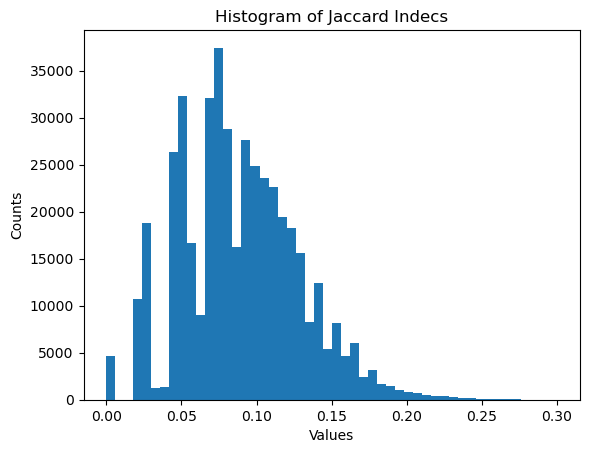

Wall time: 7.06 s


In [46]:
%%time
nlp_utils.plot_jaccard_hist(df_2, column='txt')

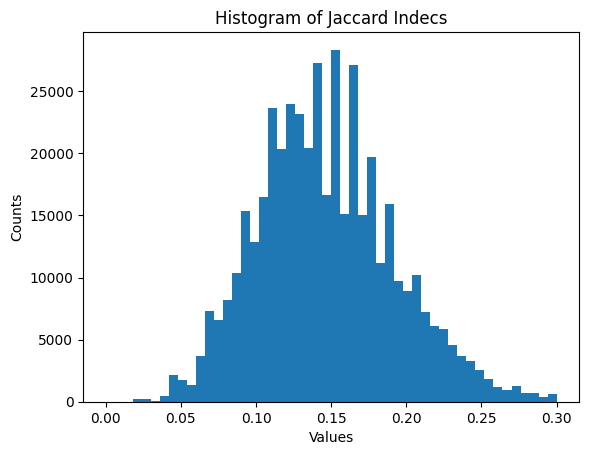

CPU times: total: 7.8 s
Wall time: 7.83 s


In [ ]:
%%time
nlp_utils.plot_jaccard_hist(df_2, 'anon_txt')

For eucledian distance

In [103]:
protected, lemma, replaced, all_words = nlp_utils.get_stat(word_dict_3)
print(f'Protected: {protected}\tLemmatized: {lemma}\t Replaced: {replaced}\t All: {all_words}')

Protected: 135	Lemmatized: 935	 Replaced: 2003	 All: 3317


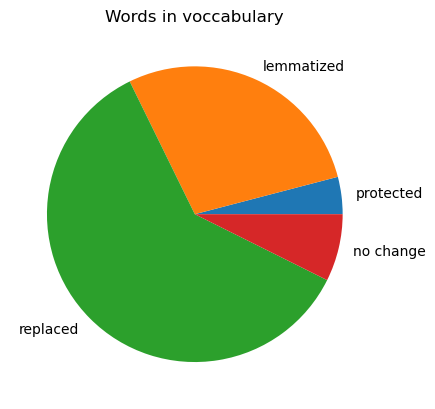

In [104]:
y = np.array([protected, lemma, replaced, (all_words - protected - lemma - replaced)])
mylabels = ['protected', 'lemmatized', 'replaced', 'no change']

plt.pie(y, labels = mylabels)
plt.title('Words in voccabulary')
plt.show()

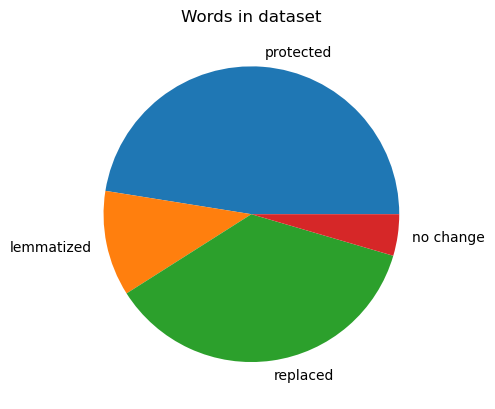

In [105]:
y = np.array([df_3['num_protected'].sum(), df_3['num_lemmatized'].sum(), df_3['num_replaced'].sum(), df_3['num_no_change'].sum()])
mylabels = ['protected', 'lemmatized', 'replaced', 'no change']

plt.pie(y, labels = mylabels)
plt.title('Words in dataset')
plt.show()

## 4) Force anonymity

### Get anonymity degree

Before replacement

In [106]:
curr_k, non_anon_indexes = anonym_utils.get_anonym_degree(docs=df_3['txt'])
print('Current k:', curr_k, '\tnumber of un-anonym. documents:', len(non_anon_indexes), '\tnumber of all documents:', len(df_2['txt']))

Current k: 1 	number of un-anonym. documents: 944 	number of all documents: 946


After replacement

### Steps:
1. Finding k nearest neighbors using approximate nearest neighbors
2. Finding the different words between the neighbors
2. Replacing the different words with *

In [110]:
force_anon_txt_annoy, neighbor_list = anonym_utils.force_anonym_using_annoy(df_3['anon_txt'], k=4)
anonym_utils.get_anonym_degree(force_anon_txt_annoy)

Start: get_anonym_degree: 1
similar_doc_ind [0, 298, 130, 422]
similar_doc_ind [1, 557, 907, 260]
similar_doc_ind [2, 754, 269, 307]
similar_doc_ind [3, 246, 6, 21]
similar_doc_ind [4, 366, 365, 188]
similar_doc_ind [5, 767, 165, 441]
similar_doc_ind [7, 424, 827, 212]
similar_doc_ind [8, 597, 498, 368]
similar_doc_ind [9, 798, 920, 569]
similar_doc_ind [10, 12, 13, 183]
similar_doc_ind [11, 125, 349, 369]
similar_doc_ind [14, 118, 16, 60]
similar_doc_ind [15, 187, 137, 819]
similar_doc_ind [17, 251, 265, 715]
similar_doc_ind [18, 486, 385, 554]
similar_doc_ind [19, 855, 34, 83]
similar_doc_ind [20, 108, 213, 593]
similar_doc_ind [22, 581, 530, 480]
similar_doc_ind [23, 784, 633, 166]
similar_doc_ind [24, 728, 425, 25]
similar_doc_ind [26, 140, 394, 278]
similar_doc_ind [27, 148, 411, 46]
similar_doc_ind [28, 330, 517, 380]
similar_doc_ind [29, 77, 372, 417]
similar_doc_ind [30, 81, 126, 638]
similar_doc_ind [31, 159, 520, 393]
similar_doc_ind [32, 48, 543, 311]
similar_doc_ind [33, 17

(2, [[133, 134], [698, 702]])

In [109]:
curr_k, non_anon_indexes = anonym_utils.get_anonym_degree(force_anon_txt_annoy)
print('Current k:', curr_k, '\tnumber of un-anonym. documents:', len(non_anon_indexes), '\tnumber of all documents:', len(df_2['txt']))

Current k: 1 	number of un-anonym. documents: 8 	number of all documents: 946


In [ ]:
df_2['force_anon_txt'] = force_anon_txt_annoy
df_2 = anonym_utils.add_neighbor_list_to_df(df_2, neighbor_list)
# Counting the number of words and *
df_2['num_of_words_after_forcing'] = df_2['force_anon_txt'].apply(lambda x: len(re.findall(r'\w+', x)))
df_2['num_of_deleting_after_forcing'] = df_2['force_anon_txt'].apply(lambda x: len(re.findall(r'\*', x)))


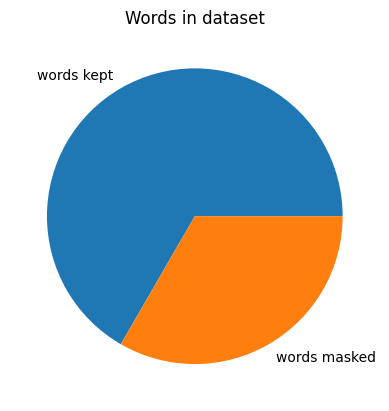

In [ ]:
y = np.array([df_2['num_of_words_after_forcing'].sum(), df_2['num_of_deleting_after_forcing'].sum()])
mylabels = ['words kept', 'words masked']

plt.pie(y, labels = mylabels)
plt.title('Words in dataset')
plt.show()

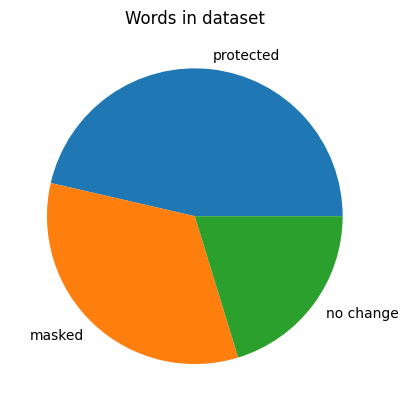

In [ ]:
y = np.array([df_2['num_protected'].sum(), df_2['num_of_deleting_after_forcing'].sum(), (df_2['num_of_words_after_forcing'] - df_2['num_protected']).sum()])
mylabels = ['protected', 'masked', 'no change']

plt.pie(y, labels = mylabels)
plt.title('Words in dataset')
plt.show()

In [ ]:
i = 1
print(df_2['txt'][i])
print(df_2['anon_txt_history'][i])
print(df_2['force_anon_txt'][i])

just awful: this was possibly the worst book i have ever read. i am amazed by the number of fans for this kind of rubbish.
(just) [worse] (this) (was) possibly (the) {bad} book (i) (have) ever read. (i) (am) {amaze} (by) (the) number (of) {fan} (for) (this) kind (of) rubbish. 
just * : this was * the bad book i have ever read . i am * by the * of * for this * of * .


## 5) Utilization tests

In [ ]:
df_21 = utilization_utils.get_vader_sentiment_for_df(df_2, ['txt', 'anon_txt', 'force_anon_txt'])
df_21

,Unnamed: 0,txt,sentiment,num_of_words,anon_txt,anon_txt_history,num_replaced,num_lemmatized,num_protected,num_no_change,force_anon_txt,num_of_words_after_forcing,num_of_deleting_after_forcing,txt_vader_sentiment_pred,anon_txt_vader_sentiment_pred,force_anon_txt_vader_sentiment_pred
0,99,"caution!: these tracks are not the ""original"" ...",0,22,"caution ! : these track are not the "" original...","caution!: (these) {track} (are) (not) (the) ""o...",0,6,11,5,"* ! : these * are not the "" original "" version...",17,6,0.0000,-0.1957,-0.1957
1,461,just awful: this was possibly the worst book i...,0,25,just worse : this was possibly the bad book i ...,(just) [worse] (this) (was) possibly (the) {ba...,1,3,14,7,just * : this was * the bad book i have ever r...,18,7,-0.5574,-0.2023,-0.5423
2,493,no lessons learned: this is one of the most di...,0,23,no lesson speak : this is one of the most pred...,(no) {lesson} {learn} (this) (is) one (of) (th...,2,4,10,7,no lesson * : this is one of * most * * i have...,13,11,-0.5563,-0.0258,-0.2960
3,578,squeem: i ordered according to the size chart ...,0,21,squeem : i order accord to the size chart for ...,squeem: (i) {order} {accord} (to) (the) size c...,0,4,10,7,* : i order * to the size * for my * and it wa...,16,6,0.0000,0.0000,0.0000
4,595,"pass: the sizes run really small, it flips up ...",0,25,"pass : the size run really small , it bag up e...","pass: (the) {size} run really small, (it) {fli...",0,5,11,9,"* : the size * * * , it bag up * * , they * it...",16,10,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,20710,excellent: prompt delivery. correct parts. you...,1,24,excellent : prompt delivery . correct secret ....,excellent: prompt delivery. correct {part} (yo...,1,5,9,9,excellent : * * . * * . you can not do * with ...,15,10,0.8622,0.8313,0.7712
942,20711,purchased minn kota mkp 3 prop from amazon.com...,1,25,purchase minn kota mkp 3 prop from amazon.com ...,{purchase} minn kota mkp 3 prop (from) amazon....,0,4,11,10,* * * * 3 * from *.* . : the * was * what i * ...,14,12,0.0000,0.0000,0.0000
943,20738,plantronics bluetooth 665 charger: this charge...,1,28,plantronic bluetooth 665 charger : this charge...,{plantronic} bluetooth 665 charger: (this) cha...,0,2,13,13,* * * * : this * is great for * when you do no...,19,10,0.7841,0.7841,0.7841
944,20784,video purchase: like the movie so i bought it....,1,18,video purchase : like the movie so i new it . ...,video purchase: like (the) movie (so) (i) {buy...,1,2,7,8,* purchase : * the * so i * it . * the * in gr...,10,8,0.8655,0.8655,0.6249


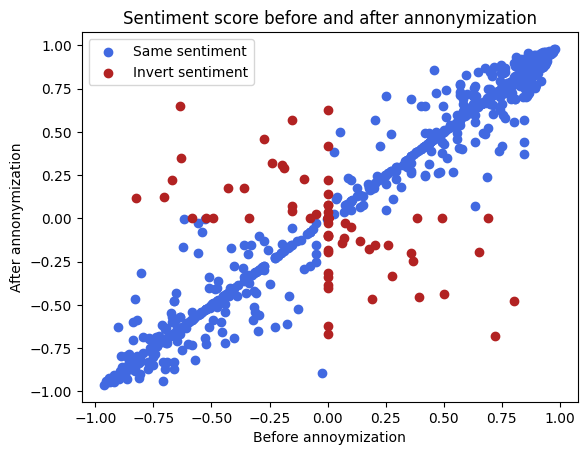

In [ ]:
utilization_utils.plot_sentiment_scatter(df_21['txt_vader_sentiment_pred'], df_21['anon_txt_vader_sentiment_pred'])

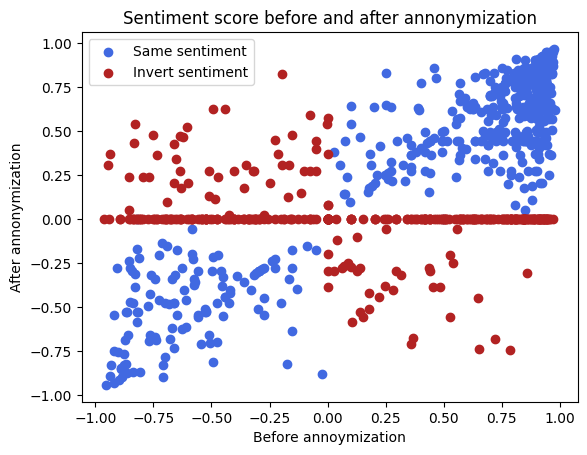

In [ ]:
#plt.scatter(df_21['txt_vader_sentiment_pred'], df_21['force_anon_txt_vader_sentiment_pred'])
utilization_utils.plot_sentiment_scatter(df_21['txt_vader_sentiment_pred'], df_21['force_anon_txt_vader_sentiment_pred'])


### Using Naive Bayes

In [ ]:
utilization_utils.sentiment_test(df_2, 'txt')

0.8858246688505911

In [ ]:
utilization_utils.sentiment_test(df_2, 'anon_txt')

0.8667835778379148

The fully anonymized text gets he highest accuracy score!

In [ ]:
utilization_utils.sentiment_test(df_2, 'force_anon_txt')

0.7736433556473437

### Using XGBoost

In [ ]:
utilization_utils.sentiment_test(df_2, 'txt')

0.8858246688505911

In [ ]:
utilization_utils.sentiment_test(df_2, 'anon_txt')

0.8667835778379148

In [ ]:
utilization_utils.sentiment_test(df_2, 'force_anon_txt')

0.7736433556473437

## Saving output

In [ ]:
filename = 'outputs/' + output_name
df_2.to_csv(filename, index=False)

### Temp and tries

In [ ]:
print(nlp_utils.stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
len(nlp_utils.stopwords.words('english'))

179

In [ ]:
len(nlp_utils.stopword_list)

179

In [ ]:
nlp_utils.add_word_list_to_stop_words('data/1000_most_common_words.txt')
len(nlp_utils.stopword_list)

1075